<a href="https://colab.research.google.com/github/plopezmp/AmI/blob/main/AmI_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autor:
*   Pablo L Matencio

Las figuras de las secciones *Decision Bounderies* y *One-vs-rest* están obtenidas del libro:

* A. Géron. *Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems*. O’Reilly Media, 2019.
* J. VanderPlas. *Python Data Science Handbook: Essential Tools for Working with Data*. O’Reilly Media, Inc., 2017.


**Preambulo:**

Montamos nuestro Google Drive donde tenemos guardado el notebook de Python.

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')
%pwd

'/content/drive/My Drive/Colab Notebooks'

---

# Clasificación

La idea simple de clasificar es determinar si una muestra o una instancia pertenece a un grupo o no pertenece a él.

Ejemplos de aplicación de clasificación son:

- Correo SPAM.
- Transacción fraudulenta en un webserver de comercio electrónico.
- Tumor maligno / benigno.
- ...



Las muestras tienen asignado un target que es la clase a la que pertenecen. De momento consideramos problemas de clasificación ***binarios***, con dos clases, donde el *target*, $y\in{0,1}$. Por convención asignamos

* $y=0$ clase **negativa** (por ejemplo, tumor benigno)
* $y=1$ clase **positiva** (por ejemplo, tumor maligno)

En los problemas multi-clase tendremos $y\in \{0,1,2,3,\ldots \}$.

Para este tipo de problemas no nos sirve un regresor lineal como lo visto hasta ahora. Queremos evaluar qué probabilidad hay de que un elemento pertenezca a cada clase y, en base a ello, decidir la clase más probable.
Por ejemplo, si estimamos que la probabilidad es mayor del 50\% querrá decir que el tumor es maligno, o, que el correo es spam.


## Estimación de probabilidades

Deseamos que los valores de la hipótesis tome valores $0\leq h_{\boldsymbol{\theta}}({\bf x}) \leq 1$.
Por tanto, no nos sirve sólo el estimador usado en el regresor lineal, sumando las features ponderadas por ${\boldsymbol{\theta}}$. Debemos aplicar a la salida del regresor lineal la función logística (o *sigmoide*):

$$
\hat{p} = h_{\boldsymbol{\theta}}({\bf x})=\sigma \left({\bf x}^{\sf T}\boldsymbol{\theta} \right)
$$

donde $\sigma(\cdot)$ es la función sigmoide, que devuelve valores entre $0$ y $1$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

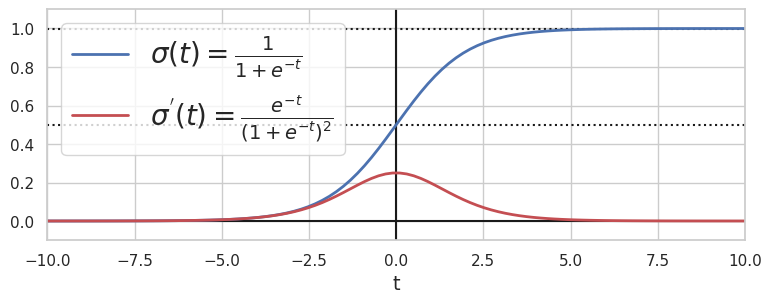

In [2]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
sigd = np.exp(-t) / (1 + np.exp(-t))**2
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-") # línea y=0
plt.plot([-10, 10], [0.5, 0.5], "k:") #línea y=0.5
plt.plot([-10, 10], [1, 1], "k:") #línea y=1
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.plot(t, sigd, "r-", linewidth=2, label=r"$\sigma^{'}(t) = \frac{e^{-t}}{(1 + e^{-t})^{2}}$")
plt.xlabel("t", fontsize=14)
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1]);

# en caso de necesitar guradar la figura usar savefig()
# plt.savefig('sigmoide.pdf', format='pdf', dpi=500, bbox_inches='tight')

Supongamos un *nuevo caso* en el problema de clasificación de tumores:

\begin{align}
    {\bf x} &= \begin{bmatrix}
           x_{0} \\
           x_{1}
         \end{bmatrix} = \begin{bmatrix}
           1 \\
           \text{tamaño_tumor}
         \end{bmatrix}
\end{align}

Supongamos que para este nuevo valor la hipótesis resulta $0.7$. Interpretamos este resultado como que el paciente tiene un 70\% de probabilidades de tener un tumor maligno, y lo podemos expresar como

$$
h_{\boldsymbol{\theta}}({\bf x}) = \Pr(y=1| {\bf x}; \boldsymbol{\theta})
$$

que podemos leer como la probabilidad de clase *positiva*, tumor maligno, dado ${\bf x}$ parametrizado por $\boldsymbol{\theta}$.

Al ser un claificador binario se cumple que:

$$
\Pr(y=0| {\bf x}; \boldsymbol{\theta}) = 1 - \Pr(y=1| {\bf x}; \boldsymbol{\theta})
$$

## Decision Boundary

El límite o frontera de decisión nos permite visualizar mejor el resultado de la hipótesis.

Cuando calculaos la hipótesis $\hat{p}$ estamos obteniendo la probabilidad $\Pr(y=1| {\bf x}; \boldsymbol{\theta})$.

Supongamos que estimamos

* $y=1$, si $\hat{p} \geq 0.5$
* $y=0$, si $\hat{p} < 0.5$

La sigmoide marca el líimite $0.5$ cuando $t=0$ es decir, ${\bf x}^{\sf T}\boldsymbol{\theta}=0$. Entonces el modelo logístico predice

* $y=1$, si $\boldsymbol{\theta}^{\sf T}{\bf x}\geq 0$
* $y=0$, si $\boldsymbol{\theta}^{\sf T}{\bf x} < 0$



## Función de Coste

Hemos visto cómo Logistic Regressión estima probabilidades y hace predicciones.

El problema que tenemos ahora es que nuestra hipótesis está compuesta por la función sigmoide y eso hace ahora que la función de coste que vimos en regresión lineal (MSE) sea **no-convexa**. Por tanto, *Gradient Descent* no nos va a dar un mínimo global.

Necesitamos una forma de entrenar el modelo para obtener el vector $\boldsymbol{\theta}$ de forma que el modelo pueda estimar con alta probabilidad muestras *positivas* ($y=1$), y, con baja probabilidad las muestras *negativas* ($y=0$).

Esta idea la conseguimos con la siguiente función de coste:

$$
\sf{Cost}\left(\hat{p}, \boldsymbol{\theta} \right) =
\begin{cases}
  -\log \left(\hat{p}\;\right) &\mbox{si } y=1 \\
  -\log\left(1- \hat{p}\;\right) & \mbox{si } y=0
\end{cases}
$$

Podemos representarla a continuación:

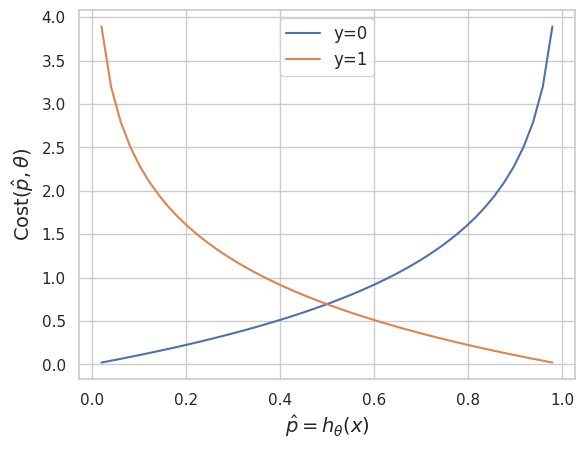

In [3]:
# usamos 'np.linspace(0,1)' pero quitando el primer y el último valor
t = np.linspace(0, 1)[1:-1]
for y in [0, 1]:
    plt.plot(t, -y * np.log(t) - (1 - y) * np.log(1 - t), label=f"y={y}")
plt.xlabel(r'$\hat{p}=h_{\theta}(x)$', fontsize=14)
plt.ylabel(r'${\sf Cost}(\hat{p},\theta)$', fontsize=14)
plt.legend(prop={'size': 12});

# en caso de necesitar guradar la figura usar savefig()
# plt.savefig('costeLogis.pdf', format='pdf', dpi=500, bbox_inches='tight')

Esta función tiene las propiedades deseadas.

* Si $y=1$ y estimamos $\hat{p}=1$, entoces ${\sf Cost}(\cdot)=0$
* Si $y=1$ y estimamos $\hat{p}=0$, entoces ${\sf Cost}(\cdot)=\infty$

* Si $y=0$ y estimamos $\hat{p}=0$, entoces ${\sf Cost}(\cdot)=0$
* Si $y=0$ y estimamos $\hat{p}=1$, entoces ${\sf Cost}(\cdot)=\infty$

La función de coste sobre todo el training set es la media del coste de todas las instancias del dataset,

$$
  J(\boldsymbol{\theta})=-\frac{1}{m}\sum_{i=1}^{m} \left[y^{(i)}\log \left( \hat{p}^{(i)} \right) + \left(1-y^{(i)}\right) \log \left(1- \hat{p}^{(i)} \right) \right]
$$

Esta ecuación es convexa lo que garantiza que habrá un valor de $\boldsymbol{\theta}$ donde la función tendrá un mínimo global. Sin embargo, no existe una ecuación *normal*, como en el regresor lineal, y debemos minimizar la función usando *Gradient Descent* u otro método.

## Gradient Descent

El algoritmo es el siguiente:

Repeat:

{
\begin{align}
\theta_{j} &\leftarrow \theta_{j} - \alpha\frac{\partial}{\partial \theta_j}J(\boldsymbol{\theta}) \\ & \forall j=0,\ldots,n
\end{align}
  }

donde $\alpha$ es un parámetro que regula la *velocidad de aprendizaje* del algoritmo. Un valor de $\alpha \approx 0$ hará que converja muy lentamente. Un valor relativamente grande de $\alpha$ puede provocar *overshooting* he incluso hacer que el algoritmo diverja.

El valor del gradiente de $J(\boldsymbol{\theta})$ queda:

$$
\frac{\partial}{\partial \theta_j}J(\boldsymbol{\theta})= \frac{1}{m}\sum_{i=1}^{m} \left(\sigma\left(\boldsymbol{\theta}^{\sf T}{\bf x}^{(i)}\right) - y^{(i)} \right)x_j^{(i)}
$$

La codificación es similar a Gradient Descent para Linear Regressor escepto que varía la función de hipótesis en la que hemos introducido la función *sigmoide*.

Si bien es un ejercicio interesante, nosotros vamos a dejar a un lado la codificación del algoritmo, y, nos centraremos en el uso de la librería `sklearn` para obtener resultados.


Antes de resolver nuestro primer problema de clasificación debemos introducir dos puntos:

1. La clasificación Multiclase
2. *Iris* dataset de `sklearn`

# Multiclass Classification

En los problemas de clasificación donde las instancias pertenecen a más de dos clases se utiliza el conocido método [one-vs-rest](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest), *ovr*.

La idea tras *one-vs-rest* es encontrar *un classificador *binario* para cada clase, es decir, cogiendo cada clase particular (sólo instancias de una clase) y agrupando el resto en una segunda clase.

**Ejemplo:** si tenemos diversas etiquetas,

* Predicción meterológica: soleado $y=1$, nuboso $y=2$, lluvioso $y=3$,

1. Computamos un clasificador binario para la clase y=1 vs la clase $y=\{ 2,3\}$. De este modo obtenemos el estimador $h_{\boldsymbol{\theta}}^{(1)}({\bf x})$.
2. Computamos un clasificador binario para la clase y=2 vs la clase $y=\{ 1,3\}$. De este modo obtenemos el estimador $h_{\boldsymbol{\theta}}^{(2)}({\bf x})$.
3. Computamos un clasificador binario para la clase y=3 vs la clase $y=\{ 1,2\}$. De este modo obtenemos el estimador $h_{\boldsymbol{\theta}}^{(3)}({\bf x})$

Es decir, ajustamos tres clasificadores:

$$
h_{\boldsymbol{\theta}}^{(i)}({\bf x}) = \Pr\left( y=i| \boldsymbol{x} \;; \boldsymbol{\theta} \right) \, , \, i=1,2,3
$$

Ante un dato nuevo que queramos clasificar escogeremos la clase $i$ que maximice la hipótesis correspondiente a esa clase,

$$
\underset{i}{\operatorname{argmax}} h_{\boldsymbol{\theta}}^{(i)}({\bf x})
$$

es decir la de probabilidad mayor.

<br>

---


# *Iris* dataset

Uno de los datasets incluidos en `scikit-learn` que más se usan es el [iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) que incluyes features de 3 clases de flor.

In [4]:
from IPython.core.display import display, Image

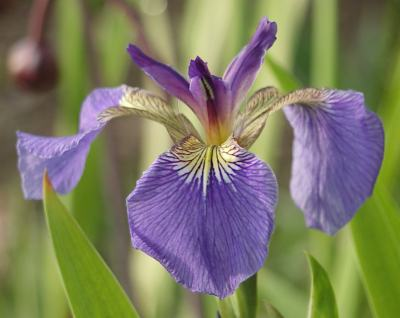

Iris Setosa



In [8]:
display(Image(filename='images/iris_setosa.jpg'))
print('Iris Setosa\n')

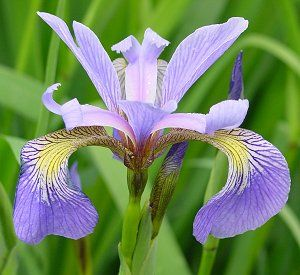

Iris Versicolor



In [9]:
display(Image(filename='images/iris_versicolor.jpg'))
print('Iris Versicolor\n')

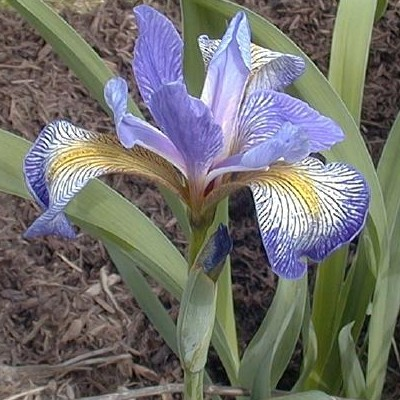

Iris Virginica



In [10]:
display(Image(filename='images/iris_virginica.jpg'))
print('Iris Virginica\n')

Las features que tiene son:
1.   Longitud de los sépalos (cm)
2.   Anchura sépalos (cm)
1.   Longitud de los pétalos (cm)
2.   Anchura de los pétalos (cm)

Además el dataset tiene:

*   El nombre de la flor ( es nuestro $y$, output):
    - `Target`: Setosa $(y=0)$, Versicolor $(y=1)$ y Virgínica $(y=2)$

`Sklearn` tiene una copia del archivo CSV con esta información e incluye una función para cargar `data` y `target` en *numpy* arrays.

In [11]:
# importamos el dataset
from sklearn.datasets import load_iris

In [12]:
# para usarlo debemos cargarlo a una variable
iris = load_iris()

Con diversos métodos podemos revisar su estructura:

* Componentes

In [13]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

* Forma de los datos (features, matrix ${\bf X}\,$):

In [14]:
n_samples, n_features = iris.data.shape
print(n_samples,n_features)

150 4


In [15]:
iris.data[:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

In [16]:
# los primeros 10 valores del sepal-length
iris.data[:10, 0]

array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9])

También podemos cargar datos accediendo al `key` `data` del diccionario

In [17]:
# 10 primeros valores del petal width
iris["data"][:10, 3:]

array([[0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.2],
       [0.4],
       [0.3],
       [0.2],
       [0.2],
       [0.1]])

* Descripción de cada feature

In [18]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

* `target`,  vector ${\bf y}$

In [19]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

<br>

## Visualización de features

Como norma intentaremos realizar la visualización de los datos. En el Iris dataset tenemos 4 features y 3 clases.

Usando colores para cada `target` podemos representar el dataset respecto a 2 features:

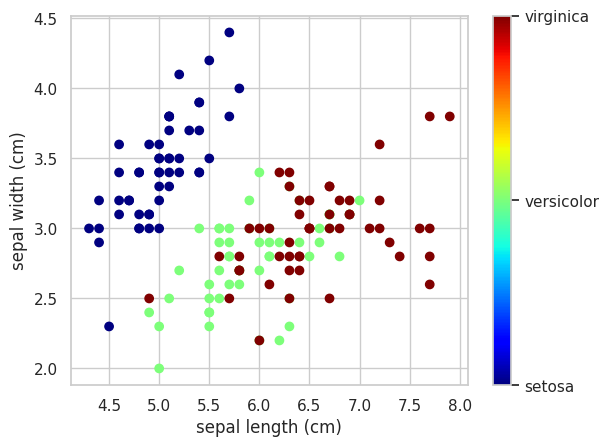

In [20]:
import matplotlib.pyplot as plt

x_index = 0
y_index = 1

formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], iris.data[:, y_index],
            c=iris.target,
            cmap=plt.colormaps['jet'].with_extremes(
                          under='lightblue', over='darkblue'))
plt.colorbar(ticks=[0,1,2], format=formatter)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index]);


Respecto a la anchura y longitud de los sépalos iris-setosa está bien diferenciado. No así iris-versicolor e iris-virgínica.

**Ejercicio:** modifique el código y pruebe con otras parejas de *features* para ver si se diferencian bien los tres tipos de iris.

A continuación estudiamos el problema de clasificación usando un estimador [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) de `Scikit-learn`.

In [21]:
from sklearn.linear_model import LogisticRegression

**Pasos:**

 1. Creamos una instancia del estimador
 2. Ajustamos el estimador con el *Iris* dataset.
 3. Hacemos una predicción de etiqueta con el estimador

In [22]:
# 1) y 2) :
model = LogisticRegression(max_iter=150)
model.fit(iris.data, iris.target)

LogisticRegression(max_iter=150)

In [23]:
# 3):
predicted = model.predict(iris.data)
# hacemos algo que no está bien porque no usamos datos distintos
# Estos datos ya están clasificados en el dataset

In [24]:
print(predicted)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [25]:
# Predicción con unas dimensiones inventadas.
model.predict([[1.1, 2.2, 3.3, 4]])

array([2])

Un valor de $\sf{2}$ corresponde a virgínica

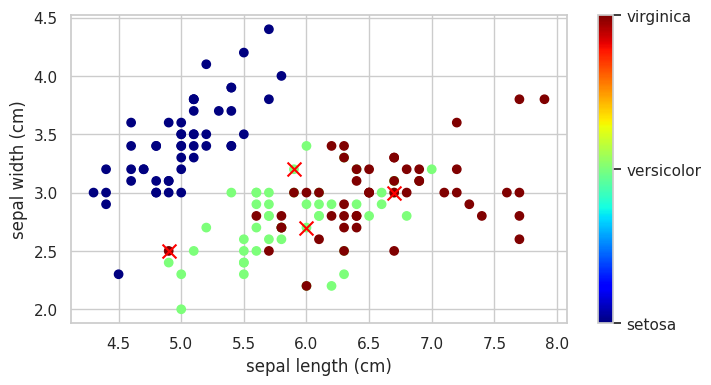

In [26]:
x_index = 0
y_index = 1
errors = predicted != iris.target
plt.figure(figsize=(8,4))
# ponemos un formater para el objeto colorbar etiquete los colores con
# el nombre correcto
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], iris.data[:, y_index],
            c=iris.target,
            #cmap=plt.cm.get_cmap('jet', 3)
            cmap=plt.colormaps['jet'].with_extremes(
                          under='lightblue', over='darkblue')
            )
plt.colorbar(ticks=[0,1,2], format=formatter)
plt.scatter(iris.data[errors,x_index], iris.data[errors,y_index],
            marker='x', c='red', s=100)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index]);

Calculamos una precisión media dado el dataset y las etiquetas:

In [27]:
model.score(iris.data,iris.target)

0.9733333333333334

Hemos tenenido 4 fallos en 150 instancias

In [28]:
1-(4.0/150)

0.9733333333333334

---

<br>

### Pipeline

Vamos a aplicar un *Pipeline* para encadenar las transformaciones que podamos realizar a los datos. Una de las tranformaciones más habituales es la **normalización** que consiste en transformar los datos de una feature para que tengan `media=0` y `standard_deviation=1`. Esto lo hace la clase `StandardScaler`, y, el objetivo es que el algoritmo de optimización funcione mejor y converja antes al valor óptimo.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
LogisticRegression()

LogisticRegression()

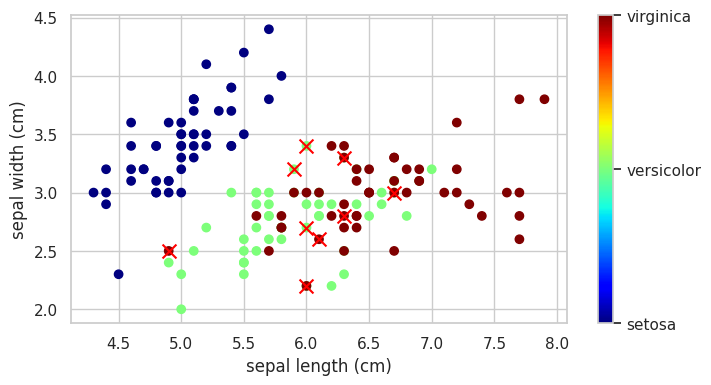

In [ ]:
# cada paso de la cadena es una tupla, 2 elems, e.g. ('scaler',StandardScaler())
# al hacer 'fit' del pipeline aplicamos cada una en el orden puesto
model = Pipeline([
                 ('scaler', StandardScaler()),
                 ('clf', LogisticRegression(penalty='l1', solver='liblinear', max_iter=200))
])
# La ventaja es que podemos aplicarla a los "training-data" y a los "test-data"

# -------------------------------------------
model.fit(iris.data, iris.target)
predicted = model.predict(iris.data)
errors = predicted != iris.target
x_index = 0
y_index = 1 # columnas de X que usamos
plt.figure(figsize=(8,4))
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], iris.data[:, y_index],
            c=iris.target,
            #cmap=plt.cm.get_cmap('jet', 3)
            cmap=plt.colormaps['jet'].with_extremes(
                          under='lightblue', over='darkblue')
            )
plt.colorbar(ticks=[0,1,2], format=formatter)
plt.scatter(iris.data[errors,0], iris.data[errors,1],
            marker='x', c='red', s=100)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index]);

In [ ]:
model.score(iris.data,iris.target)

0.94

Además de la normalización introducida, hemos especificado dos *Hiperparámetros* en el `LogisticRegressor()`: `penalty=` y `solver=`. El `solver` tiene que ver con el algoritmo de optimización usado, y, `penalty` con el tipo de **regularización**.

* `penalty='l1'` se llama *lasso*, y está relacionada con el sumatorio del valor absoluto de los parámetros $\theta$ de las features.
* `penalty='l2'` se llama *ridge*, y está relacionado con el sumatorio del valor al cuadrado de los parámetros $\theta$. Ridge es el valor por defecto del estimador.

Hay otro parámetro relacionado con el *ajuste* de la regularización que es `C=`. Dependiendo del tipo de regularización, *lasso* o *ridge*, `C=` se comporta de forma diferente.

En la sección *Advance topics in Scikit-learn* de este notebook veremos cómo podemos realizar de forma sencilla una búsqueda de los hiperparámetros que mejor clasifican. Antes vamos a profundizar en la clasificación logística viendo cómo se realiza la separación entre clases a través de una *frontera de decisión*.



## Decision Boundaries

Vamos a construir un **clasificador *binario*** que detecte la clase **Iris Virgínica** $y=2$ en base sólo a la **anchura del pétalo**, ${\bf X}[: \;, 3]$ como feature.

Primero formamos la matriz de features ${\bf X}$ y el vector target ${\bf y}$ que vamos a utilizar en el estimador.


In [ ]:
X = iris.data[:,3:]
y = (iris.target == 2).astype(np.int)

In [ ]:
print(X.shape, y.shape)

(150, 1) (150,)


In [ ]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

Vamos a visualizar las probabilidades estimadas por el modelo (`model`) para flores con anchura de pétalo entre 0cm y 3cm. Los Iris Virgínica están representados por `triángulos`, el resto (no virgínica) representados por los cuadrados azules. Vemos que, por la anchura del pétalo, las clases de flores están solapadas.

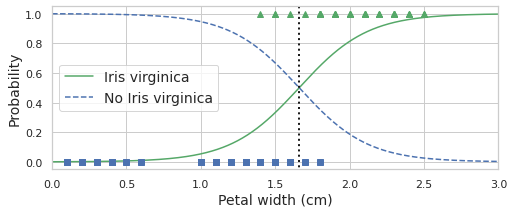

In [ ]:
X_new = np.linspace(0, 3, 1000)[:, np.newaxis]
y_proba = model.predict_proba(X_new)
##-----------
plt.figure(figsize=(8, 3))
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris virginica')
plt.plot(X_new,y_proba[:, 0], 'b--', label="No Iris virginica")
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.05, 1.05]);

In [ ]:
y_proba
# segunda columna es la sigmoide Iris virgínica

array([[9.99250016e-01, 7.49984089e-04],
       [9.99240201e-01, 7.59799387e-04],
       [9.99230257e-01, 7.69743043e-04],
       ...,
       [3.08374822e-03, 9.96916252e-01],
       [3.04400296e-03, 9.96955997e-01],
       [3.00476842e-03, 9.96995232e-01]])

In [ ]:
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]
print(decision_boundary)

[1.66066066]


Vemos que, aproximadamente, a partir de 2 cm de anchura el clasificador está seguro de que la flor es Virgínica, y, por debajo de 1 cm está seguro que no es Virginica.

Entre anchura de pétalo entre 1.4 cm y 1.8 el clasificador tiene una probabilidad en torno a 0.5 y no hay certidumbre de si es virginica.
La probabilidad la podemos ver con `predict_proba()`. Sin embargo, si pedimos una predicción con `predict()` al clasificador responde con la clase más probable. El límite lo marca el `decision boundery` que hemos calculado y está en $1.6$ cm donde la probabilidad está al 50\%. Por encima de `decision boundery` el clasificador siempre reponde que es virginica. Podemos hacer una prueba:


In [ ]:
# con predict() nos devuelve la clase más probable
model.predict([[1.68], [1.58]])

array([1, 0])

Para un tamaño de 1.68 cm predice Virgínica, y, no Virgínica para 1.58 cm

## One-vs-rest

Vamos a utilizar multiclass classification para clasificar las features de una flor en uno de las 3 clases de Iris.

Para seleccionar el tipo de optimizador tenemos que establecer el hiperparámetro `multi_class=` del estimador. Por defecto, es `'ovr'`, *one-vs-rest*.

El hiperparámetro `solver=` especificamos el tipo de método de optimización para minimizar la función de coste del regresor logístico.

Por defecto, usa una regularización `l2`, *Ridge*. El hiperparámetro `C=` sirve para ajustar el peso de la regularización en la función de coste.

In [ ]:
X = iris.data
y = iris.target

In [ ]:
model = LogisticRegression(multi_class='ovr', C=20, penalty='l2',solver='liblinear')
model.fit(X, y)

LogisticRegression(C=20, multi_class='ovr', solver='liblinear')

In [ ]:
model.predict([[1,1,5,2]])

array([2])

Es decir, si vemos una flor Iris con dimensiones de sépalo 1 cm, y pétalos de 5 cm de largo y 2 cm de ancho podemos determinar que es de clase **Virginica**. Podemos ver la probabilidad de que sea de cada una de las clases:

In [ ]:
model.predict_proba([[1,1,5,2]])

array([[1.83396538e-09, 4.93959558e-01, 5.06040440e-01]])

In [ ]:
model.score(iris.data,iris.target)

0.98

Vemos que para el clasificador hay un poco más de 50\% de probabilidades de que sea *virginica* y 49\% que sea versicolor.

---

### Ejercicio:

* Cambie el método de regresión multiclase, hiperparámetro `multi_class=` y

* compruebe las probabilidades de clasificación para la instancia [1,1,5,2]

Nota: debe conseguir ejecutar el código *sin warnings*

In [ ]:
LogisticRegression?

In [ ]:
# usamos Softmax que se parametriza con multi_class='multinomial'
model = LogisticRegression(multi_class='multinomial', C=10, max_iter=300)
model.fit(X, y)

LogisticRegression(C=10, max_iter=300, multi_class='multinomial')

In [ ]:
model.predict_proba([[1,1,5,2]])

array([[2.95027400e-10, 2.51176963e-07, 9.99999749e-01]])

---

#### Vemos como `Softmax` consigue decision boundaries más *claros*

Para comparar los decision boundaries de los dos regresores multiclase **One-Vs-Rest** y **Softmax** vamos a representar la clasificación.

Para representar la figura usamos las longitud y anchura de los pétalos:

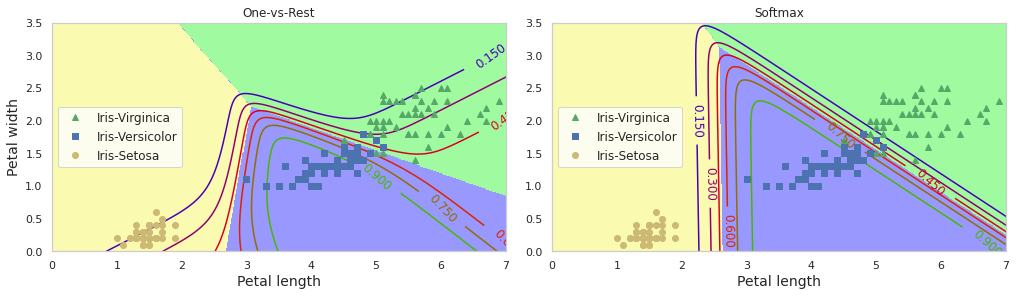

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True, figsize=(14,4))
X = iris.data[:, (2,3)]
y = iris.target
#----------------ONE-VS-REST----------------------
model = LogisticRegression(multi_class='ovr', C=10)
model.fit(X, y);

x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )

X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = model.predict_proba(X_new)
y_predict = model.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

ax1.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
ax1.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
ax1.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

ax1.contourf(x0, x1, zz, cmap=custom_cmap)
contour = ax1.contour(x0, x1, zz1, cmap=plt.cm.brg)
ax1.clabel(contour, inline=1, fontsize=12)
ax1.set_xlabel("Petal length", fontsize=14)
ax1.set_ylabel("Petal width", fontsize=14)
ax1.legend(loc="center left", fontsize=12)
ax1.set_title('One-vs-Rest')
ax1.axis([0, 7, 0, 3.5]);
#-----------------------------SOFTMAX--------------------
model = LogisticRegression(multi_class='multinomial', C=10)
model.fit(X, y);
#------------------
y_proba = model.predict_proba(X_new)
y_predict = model.predict(X_new)
zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)
ax2.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
ax2.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
ax2.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")
ax2.contourf(x0, x1, zz, cmap=custom_cmap)
contour = ax2.contour(x0, x1, zz1, cmap=plt.cm.brg)
ax2.clabel(contour, inline=1, fontsize=12)
ax2.set_xlabel("Petal length", fontsize=14)
#ax2.set_ylabel("Petal width", fontsize=14)
ax2.legend(loc="center left", fontsize=12)
ax2.set_title('Softmax')
ax2.axis([0, 7, 0, 3.5]);

**Sofmax.**
Para cada instancia calcula la probabilidad de pertenecer a una clase u otra y asigna clase con mayor probabilidad. Para calcular los parámetros de las hipótesis queremos una función de coste que penalice las probabilidades que sean pequeñas, y, estime probabilidad alta para la clase objetivo.

Esto se consigue minimizando una función de coste denominada **Entropía Cruzada** o *Cross Entropy* (A. Gerón, Pg.148).

Las *Fronteras de Decisión* son lineales (zonas de color amarillo, azul y verde). Las figuras muestran la diferencia entre OVR y Softmax de las líneas de probabilidad de la clase Iris-Versicolor, que son las líneas curvas que se pueden ver. Por ejemplo, en la fig de la derecha, la línea etiquetada con 0.450 indica un 45\% de probabilidad para la clase versicolor.

# Advance topics in `Scikit-learn`

En esta sección vamos a profundizar en algunas herramientas útiles de `sklearn` y las vamos a aplicar a nuestro modelo de aprendizaje para *iris* dataset.

## Grid Search

El problema es que no sabemos qué combinación de *Hiperparámetros* ajustan mejor el estimador a nuestro problema.

La idea de *Grid Search* consiste en probar, con los valores de *hiperparámetros* que establezcamos, todas las posibles combinaciones para determinar cuál es el mejor modelo.

Para esto está el objeto `GridSearchCV`, al que pasamos a la entrada: el modelo, y, un diccionario con los valores de los hiperparámetros que queremos probar.

*Nota*: usar `RandomizedSearchCV` si el problema es computacionamente intensivo.

En el nombre del objeto, las letras `CV` del final provienen de ***cross-validation***.


## Cross-validation

Cuando probamos un modelo nuevo queremos entrenarlo con un conjunto de datos pero deseamos probarlo con datos de prueba nuevos (no usados en el entrenamiento).

Si sólo queremos probar una combinación de hiperparámetros se puede hacer de forma sencilla. Sin embargo, si queremos probar muchos modelos determinar la parte de entranamiento y la de validación (test) resulta complicado. Además, podríamos quedarnos sin datos para entrenamiento del estimador.

Para solucionarlo la idea consiste es separar el training set en particiones denominadas *Fold*. Entonces, para cada combinación de hiperparámetros en el grid haremos:

* Probaremos entrenamientos de ese modelo diferentes folds del training set y diferentes fold de validación.
* Se calculará el score de cada una de estas pruebas, y
* Se hace la media entre todas las pruebas (todos los scores).

Para hacer esto, en problemas de clasificación, se usa el objeto `StratifiedKFold` cuya misión es conseguir que en cada fold tengamos una proporción similar de instancias de cada clase. Por ejemplo, si tenemos 100 instancias de clase 1, 100 de clase 2 y 50 de clase 3, hará que el *Fold* tenga 2/5 de clase 1, 2/5 de clase 2 y 1/5 de clase 3.

`K` es el número de *Folds*, por defecto es 5. Dependerá también de la cantidad de instancias.

Otras formas de hacer el *folding* son:

* `GroupKFold` si tenemos una meta-etiqueta que queramos usar para el fold.
* `TimeSeriesSplit` para datos que están ordenados, por ejemplo timeseries. La idea es coger para validar los datos más reciente que tengamos, y para entrenamiento los restantes.

---

<br>

## Ejercicio:

Uso de `GridSearchCV` y de `StratifiedKFold`.

* Combinar `Scaler` con `LogisticRegression` en un Pipeline
* Crear un diccionario `params` con valores de `penalty` y de `C`
* Realizar una búsqueda con cross-validation que use 5 `folds` (*stratified*).
* Usar esa búsqueda para *ajustar* y *predecir* datos de iris.

Como ejemplo puede usar:

```
from sklearn.model_selection import GridSearchCV
params = {
    'clf__C' : [0.1,0.5],
    'dr__n_components' : [5,10],
}
grid = GridSearchCV(model, params)
grid.fit(data,labels)
```



In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

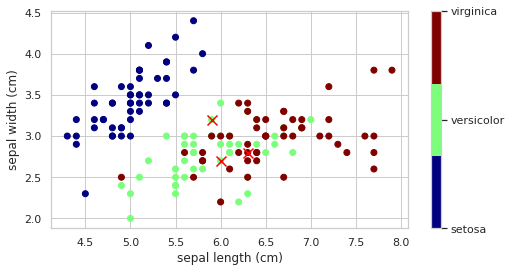

In [ ]:
# cada paso de la cadena es una tupla
# al hacer 'fit' del pipeline aplicamos cada una en el orden puesto
pipe = Pipeline([
                 ('scaler', StandardScaler()),
                 ('clf', LogisticRegression(penalty='l1', solver='liblinear', max_iter=300))
])

params = {
    'clf__C' : [0.001, 0.01, 0.1, 1, 5, 6 ,7, 8, 10, 20],
    'clf__penalty' : ['l1', 'l2'],
    'scaler__with_mean' : [True, False],
    'scaler__with_std' : [True, False]
}

model = GridSearchCV(pipe, params,
                     cv=StratifiedKFold(n_splits=5),
                     return_train_score= True
                     )

# -------------------------------------------
model.fit(iris.data, iris.target)
predicted = model.predict(iris.data)
errors = predicted != iris.target
x_index = 0
y_index = 1
plt.figure(figsize=(8,4))
formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(iris.data[:, x_index], iris.data[:, y_index],
            c=iris.target,
            cmap=plt.cm.get_cmap('jet', 3))
plt.colorbar(ticks=[0,1,2], format=formatter)
plt.scatter(iris.data[errors,0], iris.data[errors,1],
            marker='x', c='red', s=100)
plt.xlabel(iris.feature_names[x_index])
plt.ylabel(iris.feature_names[y_index]);

Podemos ver algunos de los atributos de nuestro modelo:



In [ ]:
# GridSearchCV?

In [ ]:
model.best_estimator_

Pipeline(steps=[('scaler', StandardScaler(with_mean=False, with_std=False)),
                ('clf',
                 LogisticRegression(C=6, max_iter=300, penalty='l1',
                                    solver='liblinear'))])

In [ ]:
model.best_score_

0.9800000000000001

Hemos mejorado respecto a la versión del clasificador anterior. Antes nos salía una precisión de 0.973.


In [ ]:
model.best_params_

{'clf__C': 6,
 'clf__penalty': 'l1',
 'scaler__with_mean': False,
 'scaler__with_std': False}

Cuando hacemos model.fit() estamos ejecutando 80 combinaciones de parámetros, cada una usando 5 splits, un total de cerca de 400 operaciones de aprendizaje.

Estamos usando un dataset que no es grande y los cómputos se hacen rápido.

Si tenemos un dataset grande el procesado sería más lento, pero podríamos *paralelizar* mediante `n_jobs` la ejecución si disponemos de un servidor con más CPUs. Nota: `n_jobs`  sólo mejorará cuando haya datasets grandes y tengamos muchas pruebas que realizar sobre ellos.

---

# Feature selection

Antes presentamos los dos tipos de **regularización** que habiatualmente implementan los modelos de aprendizaje: **Lasso**, `l1`, y, **Ridge**, `l2`.

A la hora de establecer la función de coste del modelo añadimos el término de regularización. Este término es función de

$$
 \text{Lasso} : J\left(\boldsymbol{\theta}\right) = \ldots + \alpha\sum_{j=1}^n |\theta_j|
$$
$$
 \text{Ridge} : J\left(\boldsymbol{\theta}\right) = \ldots + \alpha\frac{1}{2}\sum_{j=1}^n \theta_j^2
$$

Para `Linear Regression` el componente omitido por los $\ldots$ es el MSE$\left(\boldsymbol{\theta} \right)$ . En `Logistic Regressión` está al principio de este notebook.

El parámetro $\alpha$ sirve para ajustar la importancia del componente de regularización en la función de coste.

*Importante*: no confundir este $\alpha$ con el del método de optimización Gradient Descent.

<br>

Podemos probar cómo funciona la regularización con iris dataset:

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
Lasso?

In [ ]:
model = Lasso(alpha=0.00001)
# alpha=0 equivale a aproximar por mínimos cuadrados
# queremos predecir la última columna usando las 3 primeras
model.fit(iris.data[:, :-1], iris.data[:, -1])

Lasso(alpha=1e-05)

In [ ]:
print(model.coef_)

[-0.20707018  0.22263912  0.52397974]


Estos son los pesos. Vemos que los 3 pesos contribuyen los parámetros $\theta$ de las 3 primeras columnas.

Si incremento $\alpha$

In [ ]:
model = Lasso(alpha=0.001)
model.fit(iris.data[:, :-1], iris.data[:, -1])

Lasso(alpha=0.001)

In [ ]:
print(model.coef_)

[-0.1879856   0.20412168  0.51389694]


vemos que algunos pesos resultan más bajos que antes,

In [ ]:
model = Lasso(alpha=0.1)
model.fit(iris.data[:, :-1], iris.data[:, -1])

Lasso(alpha=0.1)

In [ ]:
print(model.coef_)

[0.         0.         0.38345049]


Ahora tenemos dos pesos que son $0$.

Ahora, nuestro modelo está usando una sólo de las tres features de entrada.

Otras veces nos puede intereser reducir features *antes* de realizar el `fit`, esto es, reducir las dimensiones de nuestro dataset.
Por ejemplo, si queremos usar un método de aprendizaje complejo que no escale bien con el número de columnas del dataset, o, cuando no se puede *regularizar*.

Para esto vamos a querer usar métodos que transformen nuestro datos:

* `VarianceThreshold`: mira la varianza de cada feature y si no supera un threshold la elimina. Lógicamente haremos esto antes de normalizar con un *scaler* para que no cambie la varianza.
* Otra forma es usar la salida de un modelo sencillo, por ejemplo `Lasso` o también `LinearSV[C/R]` con umbral $\approx 0.05$, y pasar ese estimador a `SelectFromModel`
* `SelectKBest` y `SelectPercentile` ayudan a seleccionar features que tienen *más importancia*  en la clasificación.
* Métodos de reducción de dimensionalidad como *Principal Component Analysis*, PCA, que se basa en la idea de *decorrelar* features. Veremos PCA más adelante en el curso.

Siguiendo el ejmplo anterior con `Lasso` podemos probar el segundo de los métodos de transformación:

In [ ]:
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(Lasso(alpha=0.1))
model.fit(iris.data, iris.target)

transformed_data = model.transform(iris.data)
print('Before', iris.data.shape)
print('After', transformed_data.shape)

Before (150, 4)
After (150, 1)


`SelectFromModel` se da cuenta de las features que tienen peso bajo tras aplicar `Lasso` y directamente las quita del dataset.

In [ ]:
model.estimator_.coef_

array([ 0.        , -0.        ,  0.40811896,  0.        ])

Tres features tienen coeficientes $0$.

Si reduzco $\alpha = 0.01$ tendré un dataset con 3 dimensiones (sólo un coeficiente es $0$)

# Otros Datasets

Existen varias formas de cargar datasets:

- **Datasets Empaquetados:** Están empaquetados en scikit-learn. Se cargan usando ``sklearn.datasets.load_*``
- **Datasets Descarga:** Los podemos descargar usando ``sklearn.datasets.fetch_*``
- **Datasets Generados:**  usando ``sklearn.datasets.make_*``

Podemos probar los datasets disponibles haciendo, por ejemplo, ``sklearn.datasets.load_ + TAB``

In [ ]:
import sklearn.datasets as skd

In [ ]:
dataset = skd.load_iris()

# Feature scaling

En problemas con múltiples features/atributos $x_0,x_1,\ldots,x_n$, es posible que, en función de los valores iniciales *Gradient Descent* converja lentamente. Para mejorar el funcionamiento de GD, la idea consiste en hacer que las diferentes features estén en un rango similar de valores. De esta forma, GD convergerá más rápidamente.

Para ello, la norma es coger las features adecuadas y escalarlas. Podríamos simplemente dividirlas por el valor máximo pero, normalmente, escogeremos el valor de la desviación estándar, $s_i$ para realizar el escalado de la feature.

$$ x_i \leftarrow \frac{x_i}{s_i} $$

Además, se suele hacer lo que se denomina **normalización de la media** que consiste en desplazar los valores de las features para que tengan media, $\mu=0$.

$$ x_i \leftarrow \frac{x_i - \mu_i}{s_i} $$
